<a href="https://colab.research.google.com/github/Jack0karev/konoha/blob/master/dqn_atari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Q-Network implementation


In [1]:
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

bash: ../xvfb: No such file or directory
env: DISPLAY=:1


In [0]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Processing game image 

Raw atari images are large, 210x160x3 by default. However, we don't need that level of detail in order to learn them.

We can thus save a lot of time by preprocessing game image, including
* Resizing to a smaller shape, 64 x 64
* Converting to grayscale
* Cropping irrelevant image parts (top & bottom)

In [0]:
from gym.core import ObservationWrapper
from gym.spaces import Box

import cv2

class PreprocessAtari(ObservationWrapper):
    def __init__(self, env):
        ObservationWrapper.__init__(self,env)
        self.img_size = (64, 64)
        self.observation_space = Box(0.0, 1.0, (self.img_size[0], self.img_size[1], 1))

    def observation(self, img):
        img = img[34:-16, :, :]
        img = cv2.resize(img, self.img_size)
        img = img.mean(-1, keepdims=True)
        img = img.astype('float32') / 255.    
        return img


3
(64, 64, 1)
Formal tests seem fine. Here's an example of what you'll get.


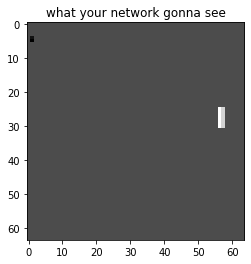

In [4]:
import gym
env = gym.make("Pong-v0") #create raw env
env = PreprocessAtari(env)

observation_shape = env.observation_space.shape
n_actions = env.action_space.n

obs = env.reset()
print(obs.ndim)
print(observation_shape)
# print(len(obs[:,1,1]))


assert obs.ndim == 3, "observation must be [batch, time, channels] even if there's just one channel"
assert obs.shape == observation_shape
assert obs.dtype == 'float32'
assert len(np.unique(obs))>2, "your image must not be binary"
assert 0 <= np.min(obs) and np.max(obs) <=1, "convert image pixels to (0,1) range"

print("Formal tests seem fine. Here's an example of what you'll get.")

plt.title("what your network gonna see")
plt.imshow(obs[:,:,0],interpolation='none',cmap='gray');



### Frame buffer

Our agent can only process one observation at a time, so we gotta make sure it contains enough information to fing optimal actions. For instance, agent has to react to moving objects so he must be able to measure object's velocity.

To do so, we introduce a buffer that stores 4 last images. This time everything is pre-implemented for you.

In [0]:
import numpy as np
from gym.spaces.box import Box
from gym.core import Wrapper
class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4, dim_order='tensorflow'):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(FrameBuffer, self).__init__(env)
        self.dim_order = dim_order
        if dim_order == 'tensorflow':
            height, width, n_channels = env.observation_space.shape
            obs_shape = [height, width, n_channels * n_frames]
        elif dim_order == 'pytorch':
            n_channels, height, width = env.observation_space.shape
            obs_shape = [n_channels * n_frames, height, width]
        else:
            raise ValueError('dim_order should be "tensorflow" or "pytorch", got {}'.format(dim_order))
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')
        
    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer
    
    def step(self, action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info
    
    def update_buffer(self, img):
        if self.dim_order == 'tensorflow':
            offset = self.env.observation_space.shape[-1]
            axis = -1
            cropped_framebuffer = self.framebuffer[:,:,:-offset]
        elif self.dim_order == 'pytorch':
            offset = self.env.observation_space.shape[0]
            axis = 0
            cropped_framebuffer = self.framebuffer[:-offset]
        self.framebuffer = np.concatenate([img, cropped_framebuffer], axis = axis)

In [7]:
def make_env():
    env = gym.make("Pong-v0")
    env = PreprocessAtari(env)
    env = FrameBuffer(env, n_frames=4, dim_order='tensorflow')
    return env

env = make_env()
x = env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape
print(n_actions)
print(state_dim)

6
(64, 64, 4)


In [8]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

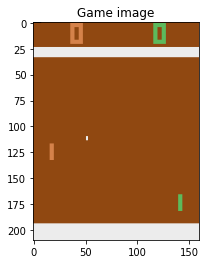

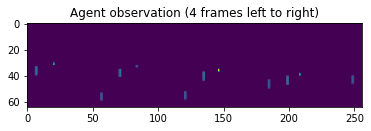

In [9]:
for _ in range(50):
    obs, _, _, _ = env.step(env.action_space.sample())


plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()
plt.title("Agent observation (4 frames left to right)")
plt.imshow(obs.transpose([0,2,1]).reshape([state_dim[0],-1]));

### Building a network

We now need to build a neural network that can map images to state q-values. This network will be called on every agent's step so it better not be resnet-152 unless you have an array of GPUs. Instead, you can use strided convolutions with a small number of features to save time and memory.

You can build any architecture you want, but for reference, here's something that will more or less work:

In [10]:
!pip install tensorflow==1.15

In [0]:
import tensorflow as tf
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [12]:
from keras.layers import Conv2D, Dense, Flatten, InputLayer
import keras
class DQNAgent:
    def __init__(self, name, state_shape, n_actions, epsilon=0, reuse=False):
        """A simple DQN agent"""
        with tf.variable_scope(name, reuse=reuse):

            self.network = keras.models.Sequential()
    
            self.network.add(Conv2D(16, (3, 3), strides=2, activation='relu', input_shape=state_shape))
            self.network.add(Conv2D(32, (3, 3), strides=2, activation='relu'))
            self.network.add(Conv2D(64, (3, 3), strides=2, activation='relu'))
            self.network.add(Flatten())
            self.network.add(Dense(256, activation='relu'))
            self.network.add(Dense(n_actions, activation='linear'))
            self.state_t = tf.placeholder('float32', [None,] + list(state_shape))
            self.qvalues_t = self.get_symbolic_qvalues(self.state_t)
            
        self.weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=name)
        self.epsilon = epsilon

    def get_symbolic_qvalues(self, state_t):
        
        qvalues = self.network(state_t)
        
        
        assert tf.is_numeric_tensor(qvalues) and qvalues.shape.ndims == 2, \
            "please return 2d tf tensor of qvalues [you got %s]" % repr(qvalues)
        assert int(qvalues.shape[1]) == n_actions
        
        return qvalues
    
    def get_qvalues(self, state_t):
        sess = tf.get_default_session()
        return sess.run(self.qvalues_t, {self.state_t: state_t})
    
    def sample_actions(self, qvalues):
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice([0, 1], batch_size, p = [1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

Using TensorFlow backend.


In [13]:
agent = DQNAgent("dqn_agent", state_dim, n_actions, epsilon=0.5)
sess.run(tf.global_variables_initializer())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Now let's try out our agent to see if it raises any errors.

In [0]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done: break
                
        rewards.append(reward)
    return np.mean(rewards)

In [15]:
evaluate(env, agent, n_games=1)

-21.0

#### The interface is fairly simple:
* `exp_replay.add(obs, act, rw, next_obs, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns observations, actions, rewards, next_observations and is_done for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

In [0]:
import numpy as np
import random

class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)
        return np.array(obses_t), np.array(actions), np.array(rewards), np.array(obses_tp1), np.array(dones)

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)

In [0]:
exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add(env.reset(), env.action_space.sample(), 1.0, env.reset(), done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(5)

assert len(exp_replay) == 10, "experience replay size should be 10 because that's what maximum capacity is"

In [0]:
def play_and_record(agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer. 
    Whenever game ends, add record with done=True and reset the game.
    :returns: return sum of rewards over time
    
    Note: please do not env.reset() unless env is done.
    It is guaranteed that env has done=False when passed to this function.
    """

    s = env.framebuffer

    reward = 0.0
    for t in range(n_steps):

        qvalues = agent.get_qvalues([s])
        action = agent.sample_actions(qvalues)[0]
        next_s, r, done, _ = env.step(action)

        exp_replay.add(s, action, r, next_s, done)
        reward += r
        if done:
            s = env.reset()
        else:
            s = next_s
    return reward
        
    

In [19]:
# testing your code. This may take a minute...
exp_replay = ReplayBuffer(20000)

play_and_record(agent, env, exp_replay, n_steps=10000)

# if you're using your own experience replay buffer, some of those tests may need correction. 
# just make sure you know what your code does
assert len(exp_replay) == 10000, "play_and_record should have added exactly 10000 steps, "\
                                 "but instead added %i"%len(exp_replay)
is_dones = list(zip(*exp_replay._storage))[-1]

assert 0 < np.mean(is_dones) < 0.1, "Please make sure you restart the game whenever it is 'done' and record the is_done correctly into the buffer."\
                                    "Got %f is_done rate over %i steps. [If you think it's your tough luck, just re-run the test]"%(np.mean(is_dones), len(exp_replay))
    
for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + state_dim
    assert act_batch.shape == (10,), "actions batch should have shape (10,) but is instead %s"%str(act_batch.shape)
    assert reward_batch.shape == (10,), "rewards batch should have shape (10,) but is instead %s"%str(reward_batch.shape)
    assert is_done_batch.shape == (10,), "is_done batch should have shape (10,) but is instead %s"%str(is_done_batch.shape)
    assert [int(i) in (0,1) for i in is_dones], "is_done should be strictly True or False"
    assert [0 <= a <= n_actions for a in act_batch], "actions should be within [0, n_actions]"
    
print("Well done!")

Well done!


### Target networks




In [0]:
target_network = DQNAgent("target_network", state_dim, n_actions)

In [0]:
def load_weigths_into_target_network(agent, target_network):
    """ assign target_network.weights variables to their respective agent.weights values. """
    assigns = []
    for w_agent, w_target in zip(agent.weights, target_network.weights):
        assigns.append(tf.assign(w_target, w_agent, validate_shape=True))
    tf.get_default_session().run(assigns)

In [22]:
load_weigths_into_target_network(agent, target_network) 

# check that it works
sess.run([tf.assert_equal(w, w_target) for w, w_target in zip(agent.weights, target_network.weights)]);
print("It works!")

It works!


### Learning with... Q-learning
Here we write a function similar to `agent.update` from tabular q-learning.

In [0]:
# placeholders that will be fed with exp_replay.sample(batch_size)
obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim)
actions_ph = tf.placeholder(tf.int32, shape=[None])
rewards_ph = tf.placeholder(tf.float32, shape=[None])
next_obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim)
is_done_ph = tf.placeholder(tf.float32, shape=[None])

is_not_done = 1 - is_done_ph
gamma = 0.99

Take q-values for actions agent just took

In [0]:
current_qvalues = agent.get_symbolic_qvalues(obs_ph)
current_action_qvalues = tf.reduce_sum(tf.one_hot(actions_ph, n_actions) * current_qvalues, axis=1)

Compute Q-learning TD error:

$$ L = { 1 \over N} \sum_i [ Q_{\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$

With Q-reference defined as

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot max_{a'} Q_{target}(s', a') $$

Where
* $Q_{target}(s',a')$ denotes q-value of next state and next action predicted by __target_network__
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.

In [25]:
# compute q-values for NEXT states with target network
next_qvalues_target = target_network.get_symbolic_qvalues(next_obs_ph)

# compute state values by taking max over next_qvalues_target for all actions
# next_actions = tf.argmax(next_qvalues_target, axis=-1)
# next_state_values_target = tf.reduce_sum(tf.one_hot(next_actions, n_actions) * next_qvalues_target, axis=1)
next_state_values_target = tf.reduce_max(next_qvalues_target, axis=-1)

# compute Q_reference(s,a) as per formula above.
reference_qvalues = rewards_ph + gamma*next_state_values_target*is_not_done

# Define loss function for sgd.
td_loss = (current_action_qvalues - reference_qvalues) ** 2
td_loss = tf.reduce_mean(td_loss)

train_step = tf.train.AdamOptimizer(1e-3).minimize(td_loss, var_list=agent.weights)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
sess.run(tf.global_variables_initializer())

In [27]:
for chk_grad in tf.gradients(reference_qvalues, agent.weights):
    error_msg = "Reference q-values should have no gradient w.r.t. agent weights. Make sure you used target_network qvalues! "
    error_msg += "If you know what you're doing, ignore this assert."
    assert chk_grad is None or np.allclose(sess.run(chk_grad), sess.run(chk_grad * 0)), error_msg

assert tf.gradients(reference_qvalues, is_not_done)[0] is not None, "make sure you used is_not_done"
assert tf.gradients(reference_qvalues, rewards_ph)[0] is not None, "make sure you used rewards"
assert tf.gradients(reference_qvalues, next_obs_ph)[0] is not None, "make sure you used next states"
assert tf.gradients(reference_qvalues, obs_ph)[0] is None, "reference qvalues shouldn't depend on current observation!" # ignore if you're certain it's ok
print("Splendid!")

Splendid!


### Main loop

It's time to put everything together and see if it learns anything.

In [0]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

%matplotlib inline

mean_rw_history = []
td_loss_history = []

In [0]:
exp_replay = ReplayBuffer(10**5)
play_and_record(agent, env, exp_replay, n_steps=10000)

def sample_batch(exp_replay, batch_size):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(batch_size)
    return {
        obs_ph:obs_batch, actions_ph:act_batch, rewards_ph:reward_batch, 
        next_obs_ph:next_obs_batch, is_done_ph:is_done_batch
    }

buffer size = 100000, epsilon = 0.40895


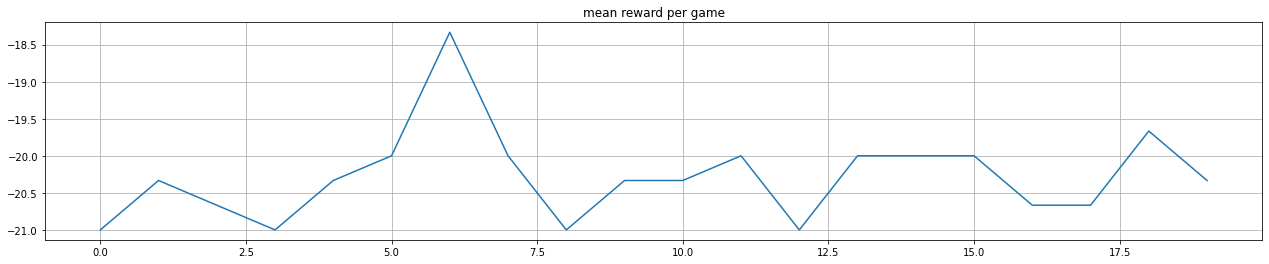

In [0]:
for i in trange(10**5 * 5):
    
    # play
    play_and_record(agent, env, exp_replay, 10)
    
    # train
    _, loss_t = sess.run([train_step, td_loss], sample_batch(exp_replay, batch_size=64))
    td_loss_history.append(loss_t)
    
    # adjust agent parametersewma
    if i % 500 == 0:
        load_weigths_into_target_network(agent, target_network)
        agent.epsilon = max(agent.epsilon * 0.99, 0.01)
        mean_rw_history.append(evaluate(make_env(), agent, n_games=3))


    if i % 100 == 0:
        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))
        df_ewm = pd.DataFrame(np.array(td_loss_history))
        plt.figure(figsize=[48, 4])
        plt.subplot(1,2,1)
        plt.title("mean reward per game")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(loss_t)
        plt.figure(figsize=[48, 4])
        plt.subplot(1,2,2)
        plt.title("TD loss history (moving average)")
        plt.plot(df_ewm.ewm( span=100, min_periods=100).mean())
        plt.grid()
        plt.show()
        
        

# Выводы:

Во-первых стоит отметить, что мы имеем дело с обучением без учителя, а как результат у нас не будет монотонной сходимость к экстремуму 
* **TD loss**  показывает квадрат ошибки между текущим значение Q-value агента и Q-value таргета. В целом это значение может как расти так и падать, что свидетельствует о процессе обучения, но если агент перестанет обучаться не достигнув плюс минус нормального результата, то это уже не хорошо, т.е. агент не обучается, значит награда задана неправильно или ещё что-нибудь)
* **mean reward** является ожидаемой суммой r (s, a), которую агент получает за весь игровой сеанс. Он будет колебаться, но в среднем он должен расти со временем (после нескольких тысяч итераций ...). Для того, чтобы начать нормально обучать должно пройти около 10тыс - 20тыс итераций, чтобы раскачалась модель
* **buffer size** - чем больше тем лучше)
* **epsilon** - готовность агента исследовать. Если у агента уже 0,01 эпсилон до того, как его среднее вознаграждение превысит 0 это означает, что нужно его увеличить.
* Кроме того, не стоит обращать внимание на первые шаги, потому что агент должен понять за что он получает награду, а потом он уже меньше колеблется и его средняя награда начинает расти. Сначала он будет практически сразу проигрывать, потому начнет проигрывать дольше, и в итоге будет побеждать





# Save weights of model

In [95]:
### Список переменныех, которые сохраняются

[<tf.Variable 'dqn_agent/conv2d_1/kernel:0' shape=(3, 3, 4, 16) dtype=float32>,
 <tf.Variable 'dqn_agent/conv2d_1/bias:0' shape=(16,) dtype=float32>,
 <tf.Variable 'dqn_agent/conv2d_2/kernel:0' shape=(3, 3, 16, 32) dtype=float32>,
 <tf.Variable 'dqn_agent/conv2d_2/bias:0' shape=(32,) dtype=float32>,
 <tf.Variable 'dqn_agent/conv2d_3/kernel:0' shape=(3, 3, 32, 64) dtype=float32>,
 <tf.Variable 'dqn_agent/conv2d_3/bias:0' shape=(64,) dtype=float32>,
 <tf.Variable 'dqn_agent/dense_1/kernel:0' shape=(3136, 256) dtype=float32>,
 <tf.Variable 'dqn_agent/dense_1/bias:0' shape=(256,) dtype=float32>,
 <tf.Variable 'dqn_agent/dense_2/kernel:0' shape=(256, 4) dtype=float32>,
 <tf.Variable 'dqn_agent/dense_2/bias:0' shape=(4,) dtype=float32>]
 
 [<tf.Variable 'target_network/conv2d_4/kernel:0' shape=(3, 3, 4, 16) dtype=float32>,
 <tf.Variable 'target_network/conv2d_4/bias:0' shape=(16,) dtype=float32>,
 <tf.Variable 'target_network/conv2d_5/kernel:0' shape=(3, 3, 16, 32) dtype=float32>,
 <tf.Variable 'target_network/conv2d_5/bias:0' shape=(32,) dtype=float32>,
 <tf.Variable 'target_network/conv2d_6/kernel:0' shape=(3, 3, 32, 64) dtype=float32>,
 <tf.Variable 'target_network/conv2d_6/bias:0' shape=(64,) dtype=float32>,
 <tf.Variable 'target_network/dense_3/kernel:0' shape=(3136, 256) dtype=float32>,
 <tf.Variable 'target_network/dense_3/bias:0' shape=(256,) dtype=float32>,
 <tf.Variable 'target_network/dense_4/kernel:0' shape=(256, 4) dtype=float32>,
 <tf.Variable 'target_network/dense_4/bias:0' shape=(4,) dtype=float32>]

[<tf.Variable 'target_network/conv2d_4/kernel:0' shape=(3, 3, 4, 16) dtype=float32>,
 <tf.Variable 'target_network/conv2d_4/bias:0' shape=(16,) dtype=float32>,
 <tf.Variable 'target_network/conv2d_5/kernel:0' shape=(3, 3, 16, 32) dtype=float32>,
 <tf.Variable 'target_network/conv2d_5/bias:0' shape=(32,) dtype=float32>,
 <tf.Variable 'target_network/conv2d_6/kernel:0' shape=(3, 3, 32, 64) dtype=float32>,
 <tf.Variable 'target_network/conv2d_6/bias:0' shape=(64,) dtype=float32>,
 <tf.Variable 'target_network/dense_3/kernel:0' shape=(3136, 256) dtype=float32>,
 <tf.Variable 'target_network/dense_3/bias:0' shape=(256,) dtype=float32>,
 <tf.Variable 'target_network/dense_4/kernel:0' shape=(256, 4) dtype=float32>,
 <tf.Variable 'target_network/dense_4/bias:0' shape=(4,) dtype=float32>]

In [77]:
  assigns = []
  for w_agent, w_target in zip(agent.weights, target_network.weights):
    assigns.append(tf.assign(w_target, w_agent, validate_shape=True))
  tf.get_default_session().run(assigns)
  saver = tf.train.Saver()
  saver.save(sess, "model")

'model'

In [85]:
!ls

checkpoint			model.ckpt.meta		   model.meta
model.ckpt.data-00000-of-00001	model.data-00000-of-00001  sample_data
model.ckpt.index		model.index


# Load weights - А не как, я не сраный умный, хех :)


In [118]:
tf.reset_default_graph()


# Access saved Variables directly
print(sess.run('target_network/conv2d_5/bias:0'))

InvalidArgumentError: ignored